In [1]:
%matplotlib inline

from __future__ import division
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from matplotlib import rc
rc('savefig', dpi=100)

from pyhsmm.util.text import progprint_xrange
from pyhsmm.util.stats import whiten, diag_whiten

import flyball.load as load

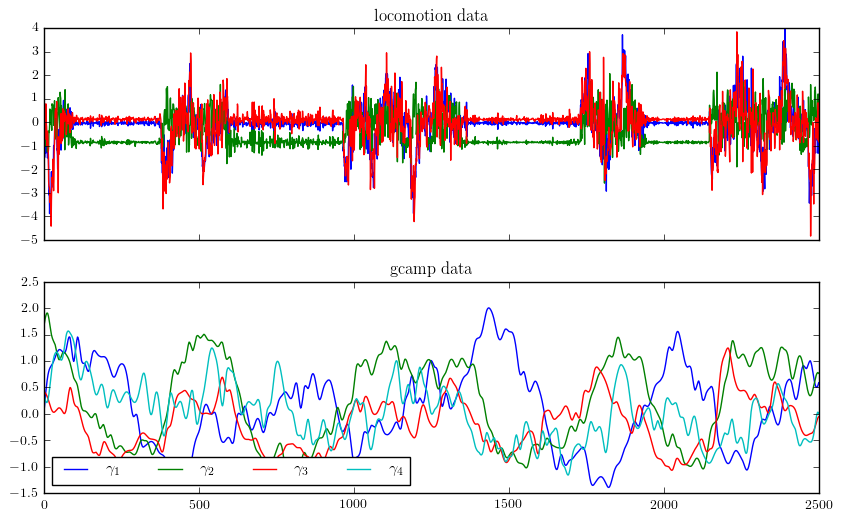

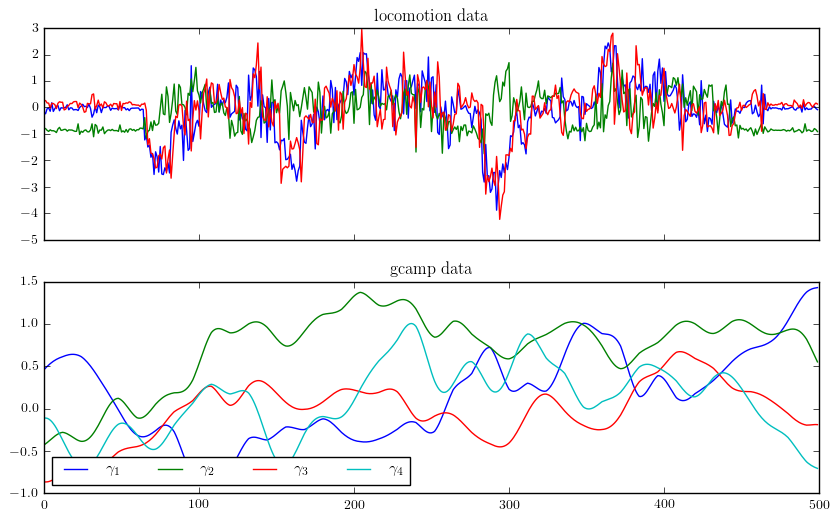

In [2]:
reload(load)

data = diag_whiten(load.load())
gcamp_data, locomotion_data = load.split_data(data)

load.plot_data(data[:2500])
load.plot_data(data[900:1400])

### fitting and movie making

In [3]:
from moviepy.video.io.bindings import mplfig_to_npimage
from moviepy.editor import VideoClip

def make_movie(model):
    num_plots = 1
    plot_slice = slice(0, 5000)

    plt.set_cmap('rainbow')
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6))
    axes = axes if num_plots > 1 else [axes]
    for s, ax in zip(model.states_list, axes):
        model.plot_stateseq(s, ax=ax, draw=False, plot_slice=plot_slice)
    ax = plt.gca()

    def make_frame_mpl(t):
        model.resample_model()
        for s, ax in zip(model.states_list, axes):
            model.plot_stateseq(s, ax=ax, update=True, draw=False, plot_slice=plot_slice)
        return mplfig_to_npimage(fig)
    
    def make_clip(num_samples, fps=30):
        dur = num_samples / fps
        return VideoClip(make_frame_mpl, duration=dur).ipython_display(fps=fps)

    return make_clip

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



### apply an SLDS to the locomotion data

In [4]:
from pyslds.models import WeakLimitStickyHDPHMMSLDS
from autoregressive.distributions import AutoRegression
from pyhsmm.basic.distributions import Regression, Gaussian

def build_slds(data, Nmax, P, kappa):
    D = data.shape[1]

    dynamics_distns = [
        AutoRegression(
            nu_0=P+2,S_0=np.eye(P),M_0=np.zeros((P,P)),K_0=0.1*np.eye(P))
        for _ in xrange(Nmax)]

    emission_distns = [
        Regression(nu_0=D+2, S_0=np.eye(D), M_0=np.zeros((D, P)), K_0=np.eye(P))
        for _ in xrange(Nmax)]


    init_dynamics_distns = [
        Gaussian(nu_0=P+2,sigma_0=3.*np.eye(P),mu_0=np.zeros(P),kappa_0=0.01)
        for _ in xrange(Nmax)]

    from pyslds.models import WeakLimitStickyHDPHMMSLDS

    model = WeakLimitStickyHDPHMMSLDS(
        dynamics_distns=dynamics_distns,
        emission_distns=emission_distns,
        init_dynamics_distns=init_dynamics_distns,
        kappa=kappa, alpha=3., gamma=3., init_state_distn='uniform')

    model.add_data(data)
    model.resample_states()
    
    return model

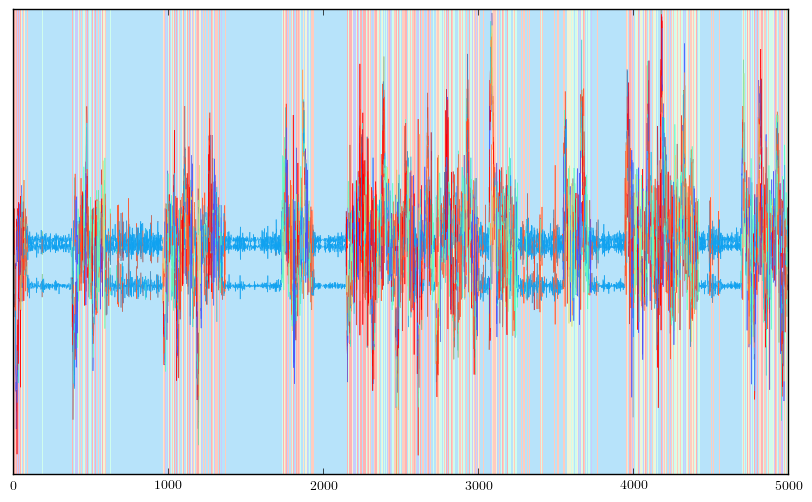

In [5]:
slds = build_slds(locomotion_data, Nmax=10, P=10, kappa=1000)
make_movie(slds)(num_samples=500)

In [6]:
np.bincount(np.concatenate(slds.stateseqs))

array([   19,  9207,    28,   655, 23732,  8912,  4188,  4889,    18,  2352])

### apply an AR-HMM to the locomotion data

In [7]:
from autoregressive.models import FastARWeakLimitStickyHDPHMM
from autoregressive.distributions import AutoRegression

def build_arhmm(data, Nmax, nlags, affine, kappa, num_seqs=1):
    ndim = data.shape[1]

    model = FastARWeakLimitStickyHDPHMM(
        alpha=5., gamma=5., init_state_distn='uniform',
        kappa=kappa,
        obs_distns=[
            AutoRegression(
                nu_0=ndim+1,
                S_0=np.eye(ndim),
                M_0=np.zeros((ndim, ndim*nlags+affine)),
                K_0=np.eye(ndim*nlags+affine),
                affine=affine)
            for state in range(Nmax)])

    for d in np.array_split(data, num_seqs):
        model.add_data(d)
        
    return model

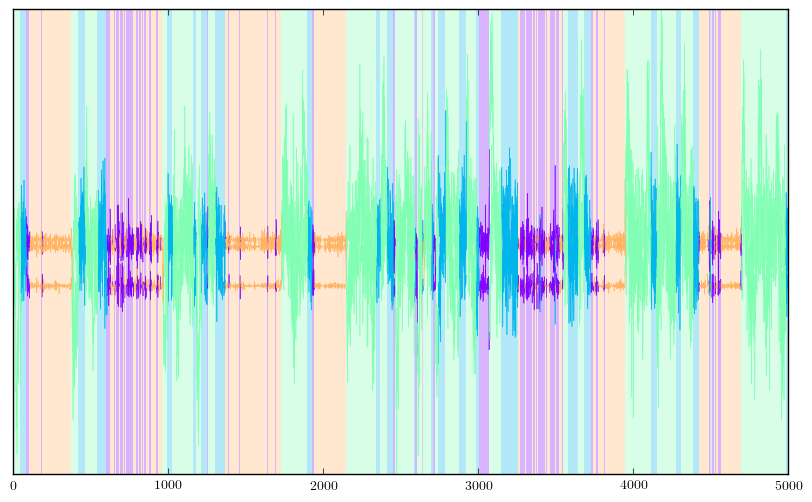

In [10]:
arhmm = build_arhmm(locomotion_data, Nmax=5, affine=False, nlags=5, kappa=1e5, num_seqs=8)
make_movie(arhmm)(num_samples=100)

In [11]:
np.bincount(np.concatenate(arhmm.stateseqs))

array([    0, 13784, 24652,  8443,  7081])